# Astrobee Example

In [47]:
# If first time running this code on a personal computer
# using Pkg
# Pkg.instantiate()

### Script / GuSTO Initialization

In [48]:
# Initializing script
using LinearAlgebra
using Ipopt
using JuMP
using DifferentialEquations
using NLsolve
using Plots

include("./Models/astrobee.jl")
include("./SCP/gusto_problem.jl")
include("astrobee_plotting.jl")

# Number of time-discretization points and maximum number of GuSTO iterations
N, max_it = 50, 20

# Defining the model, the initial strategy and each convex subproblem
model      = Astrobee()
Xp,Up      = initialize_trajectory(model,N)
SCPproblem = GuSTOProblem(model,N,Xp,Up)

# Defining GuSTO parameters
(Delta0, omega0, omegamax, epsilon, rho0,
        rho1, beta_succ, beta_fail, gamma_fail, 
        convergence_threshold) = get_initial_gusto_parameters(model)

Initializing the ISS.

(5.0, 100.0, 1.0e9, 0.001, 5.0, 20.0, 2.0, 0.5, 5.0, 0.05)

### GuSTO Algorithm

In [49]:
# Defining penalization weights, trust-region radius and the list of solutions
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# GuSTO loop
success, it = false, 1
while it < max_it                                                               && 
      !(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    println("-----------\nIteration $it\n-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp, Up                    = copy(X), copy(U)
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(     SCPproblem, model)
    set_parameters(    SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(       SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    # Solving the convex subproblem
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol, U_sol = JuMP.value.(SCPproblem.X), JuMP.value.(SCPproblem.U)
    
    # -----------
    # GuSTO Logic
    
    # Trust-region constraints are satisfied
    if is_in_trust_region(model,X_sol,U_sol,Xp,Up,Delta)
        
        # Computing accuracy ratio rho
        rho = accuracy_ratio(SCPproblem,model,X_sol,U_sol,Xp,Up)

        # Too coarse linearization: reject solution
        if rho > rho1
            println("Reject solution (the linearization is too coarse).")
            Delta, omega = beta_fail*Delta, omega
            success      = false
        
        # Accepting solution
        else
            println("Accept solution.")
            X, U    = copy(X_sol), copy(U_sol)
            success = true
            
            # Check precision of linearization
            if rho < rho0
                Delta = min(beta_succ*Delta,Delta0) # Optimal / Precise 
            else
                Delta = Delta                       # Imprecise - bad
            end
            
            # Check satisfaction of state constraints
            if satisfies_state_inequality_constraints(SCPproblem,model,X_sol,U_sol,Xp,Up,Delta)
                omega = omega0 # All constraints are satisfied - good
            else
                # State constraints are not satisfied: increase penalization weights
                println("Solution does not satisfy state constraints, increasing omega.")
                if it > 2
                    omega   = gamma_fail*omega
                    success = false
                end
            end
        end
        
    # Trust-region constraints are NOT satisfied
    else
        println("Reject solution (the trust region constraints are not satisfied).")
        Delta   = Delta
        omega   = gamma_fail*omega
        success = false
    end

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
    println("omega  = $omega")
#     println("delta  = $Delta")
    println("metric = $(convergence_metric(model,X,U,Xp,Up))")
#     println(" ")
end

-----------
Iteration 1
-----------
Accept solution.
[gusto_problem.jl] - poly_obstacles_constraint violated at i=3 and k=23
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega  = 100.0
metric = 0.7258290654869592
-----------
Iteration 2
-----------
Accept solution.
[gusto_problem.jl] - poly_obstacles_constraint violated at i=3 and k=19
[gusto_problem.jl] - poly_obstacles_constraint violated at i=3 and k=20
[gusto_problem.jl] - poly_obstacles_constraint violated at i=3 and k=21
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega  = 100.0
metric = 0.5925216493532379
-----------
Iteration 3
-----------
Accept solution.
[gusto_problem.jl] - poly_obstacles_constraint violated at i=3 and k=18
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega  = 500.0
metric = 0.39393534863683577
-----------
Iteration 4
-----------
Accept solution.
Parameters:
omega  = 100.0
metric = 0.17042662697453181
-----------
Itera

# Plots

In [50]:
true_cost(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1])

0.023733171088302907

In [51]:
convergence_metric(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1])

0.03314655365050179

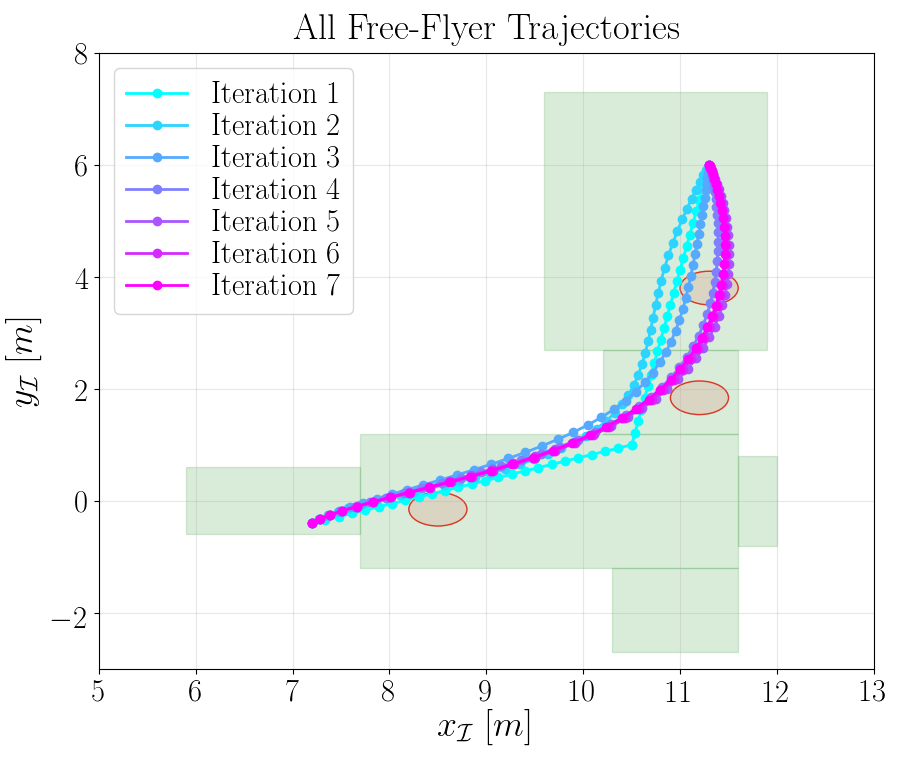

Done Plotting

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = plt_solutions(::GuSTOProblem, ::Astrobee, ::Array{Any,1}, ::Array{Any,1}; xlims::Array{Float64,1}, ylims::Array{Float64,1}, figsize::Tuple{Int64,Int64}, B_plot_labels::Bool) at astrobee_plotting.jl:436
└ @ Main /home/thomas/Documents/research/CSM/GuSTO_quad_astrobee/astrobee_plotting.jl:436


In [52]:
include("astrobee_plotting.jl")
plt_solutions(SCPproblem, model, X_all, U_all, xlims=[5.,13.], ylims=[-3.,8,])
print("Done Plotting")

In [53]:
# i=8
# plt.plot(1:N, X_all[end][i,:], "g")
# plt.plot(1:N, X_all[end-1][i,:], "b--")

In [54]:
# i=4
# plt.plot(1:N-1, U_all[end][i,:], "g")
# plt.plot(1:N-1, U_all[end-1][i,:], "b--")

In [55]:
# include("Models/polygonal_obstacles.jl")
# include("Models/ISS.jl")
# include("astrobee_plotting.jl")
# plt_final_solution_ISS(SCPproblem, model, X_all[end], U_all[end])
# # plt_final_solution_ISS(SCPproblem, model, X_all[end], U_all[end], [2,3])
# print("Done")

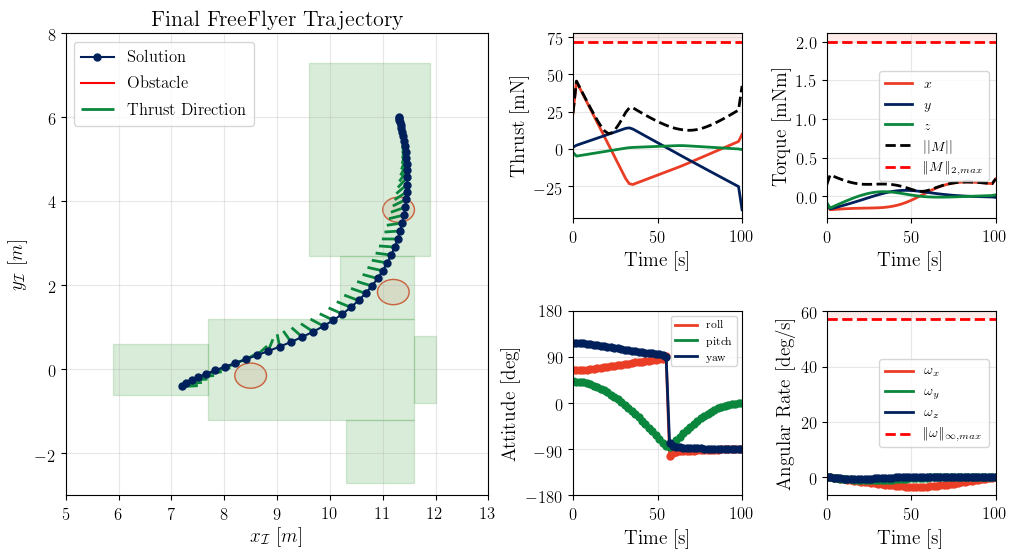

In [56]:
include("utils/csm_ff_plots.jl")
csm_plots_freeflyer(X_all, U_all, N, model)

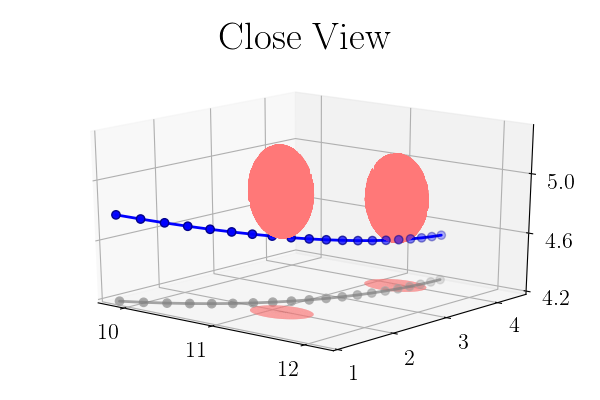

In [57]:
include("astrobee_plotting.jl")
plot3D_final_solution(SCPproblem, model, X_all[end], U_all[end])

In [58]:
# include("astro_iss_plot.jl")
# plt_ISS()